In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import matplotlib.pyplot as plt
from matplotlib import style

from collections import Counter
import re
from geotext import GeoText
from wordcloud import WordCloud
from PIL import Image

import math
import string
import random
import pickle

from sklearn.cross_validation import train_test_split
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
style.use('fivethirtyeight')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# constants
DATA_PATH = '../data/'
JOBS_PATH = DATA_PATH + 'jobs/'
IMG_PATH = DATA_PATH + 'images/'

In [3]:
try:
    df = pd.read_pickle(JOBS_PATH + 'monster-jobs.pickle')
except FileNotFoundError:
    df = pd.read_csv(JOBS_PATH + 'monster-jobs.csv',encoding = 'ISO-8859-1')
    df.to_pickle(JOBS_PATH + 'monster-jobs.pickle')

LENGTH = len(df)

In [4]:
# separate columns
descriptions = df['job_description']
job_titles = df['job_title']
organization = df['organization']
sector = df['sector']

In [5]:
# words to not consider when doing analysis
stop_words = set(stopwords.words('english'))
# additional stop words found in dataset
additional_stop_words = set(['Time','\x89ÛÒ','MONS LOG VARS', 'px', 'body', 'margin', 'overflow', 'visible', 'important', 'ejb header', 'color', 'font family', 'Verdana','Monster com', '','Job','OpportunityAffirmative','Opportunity', 'monster','Most', 'Date', 'Apex', 'monster.com','Monstercom','Monster com' 'MONS_LOG_VARS', 'var', 'ejb_header', 'JobID', 'Of' ])
stop_words = stop_words.union(additional_stop_words)

In [6]:

# returns a counter object containing all locations mined from location column
def get_location_counter(column):
    
    all_noun_tokens = []
    location_tokens = []
    
    for elm in column:
        # tokenize location as a sentence
        # needed because some elements contain alot of text
        sent = sent_tokenize(elm)
        for sent_tok in sent:
            # tokenize sentence
            words = word_tokenize(sent_tok)
            # tag words by part of speech
            tagged = nltk.pos_tag(words)
            nouns = []
            # collect all proper nouns
            for tup in tagged:
                if tup[1] == 'NNP':
                    nouns.append(tup[0])
            all_noun_tokens.append(nouns)
    
    for token in all_noun_tokens:
        tagged = nltk.pos_tag(token)
        # create named entity from all nouns
        namedEnt = nltk.ne_chunk(tagged, binary=True)
        for ent in namedEnt:
            if(hasattr(ent, 'label') and ent.label() == 'NE'):
                location_str = ' '.join(e[0] for e in ent)
                # find combined entities such as San Jose, Las Vegas, etc
                loc = GeoText(location_str)
                if(len(loc.cities) > 0):
                    location_tokens.append(location_str.title())
    return Counter(location_tokens)

# creates word cloud of locations mined from dataset
# focuses on cities
def make_US_word_cloud(locations):
    # https://lollyjane.com/wp-content/uploads/2014/05/free-united-states-silhouette.jpg
    us_img = np.array(Image.open('../data/images/us-stencil.png'))
    
    wc = WordCloud(background_color="white", max_words=2000, mask=us_img,
                  stopwords=stop_words)
    wc.generate_from_frequencies(locations)
    wc.to_file(IMG_PATH + 'monster-jobs-location-word-cloud.png')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [7]:
locations = df['location']
loc_counter = get_location_counter(locations)

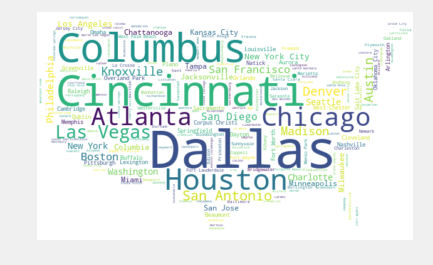

In [8]:
make_US_word_cloud(loc_counter)

In [9]:
'''
function to strip word of any location and punctuation and replaces punctuation with space 
'''
def strip_word_remove_location(word):
    # map punctuation to space
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    word = word.translate(translator)
    loc = GeoText(word)
    return word if len(loc.cities) == 0 and word != 'nan' else ''

def get_counter_object(column):
    all_tokens = []
    for row in column:
        words = word_tokenize(str(row))
        for word in words:
            word = strip_word_remove_location(word)
            word = word.strip()
            if (not word in stop_words and len(word) > 0):
                all_tokens.append(word)
    return Counter(all_tokens)

In [10]:
# data used for plotting
org_dict = df['organization'].value_counts().head(10).to_dict()
sect_dict = df['sector'].value_counts().head(10).to_dict()

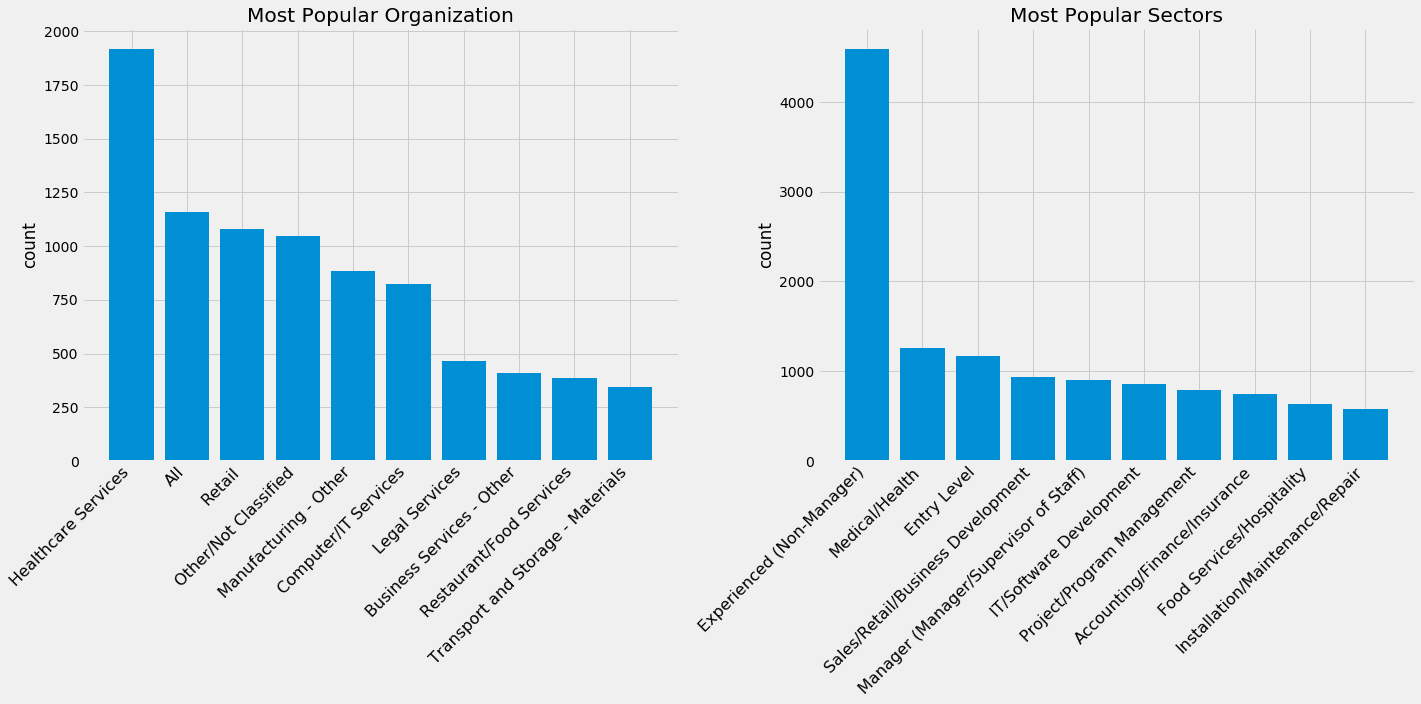

In [11]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

ax1.bar(range(len(org_dict)),org_dict.values(), align='center')
ax1.set_xticks(range(10))
ax1.set_xticklabels(org_dict.keys(), rotation=45, fontsize=16, ha='right')
ax1.set_title('Most Popular Organization')
ax1.set_ylabel('count')

ax2.set_title('Most Popular Sectors')
ax2.set_xticks(range(10))
ax2.bar(range(len(sect_dict)),sect_dict.values(), align='center')
ax2.set_xticklabels(sect_dict.keys(), rotation=45, fontsize=16, ha='right')
ax2.set_ylabel('count')

f.tight_layout()
plt.show()

In [27]:
def generate_dict_from_tup_list(tup_list):
    return {tup[0] : tup[1] for tup in tup_list}

In [28]:
org_counter = get_counter_object(organization).most_common(100)
org_counter = generate_dict_from_tup_list(org_counter)
sec_counter = get_counter_object(sector).most_common(100)
sec_counter = generate_dict_from_tup_list(sec_counter)
desc_counter = get_counter_object(descriptions).most_common(100)
desc_counter = generate_dict_from_tup_list(desc_counter)
title_counter = get_counter_object(job_titles).most_common(100)
title_counter = generate_dict_from_tup_list(title_counter)

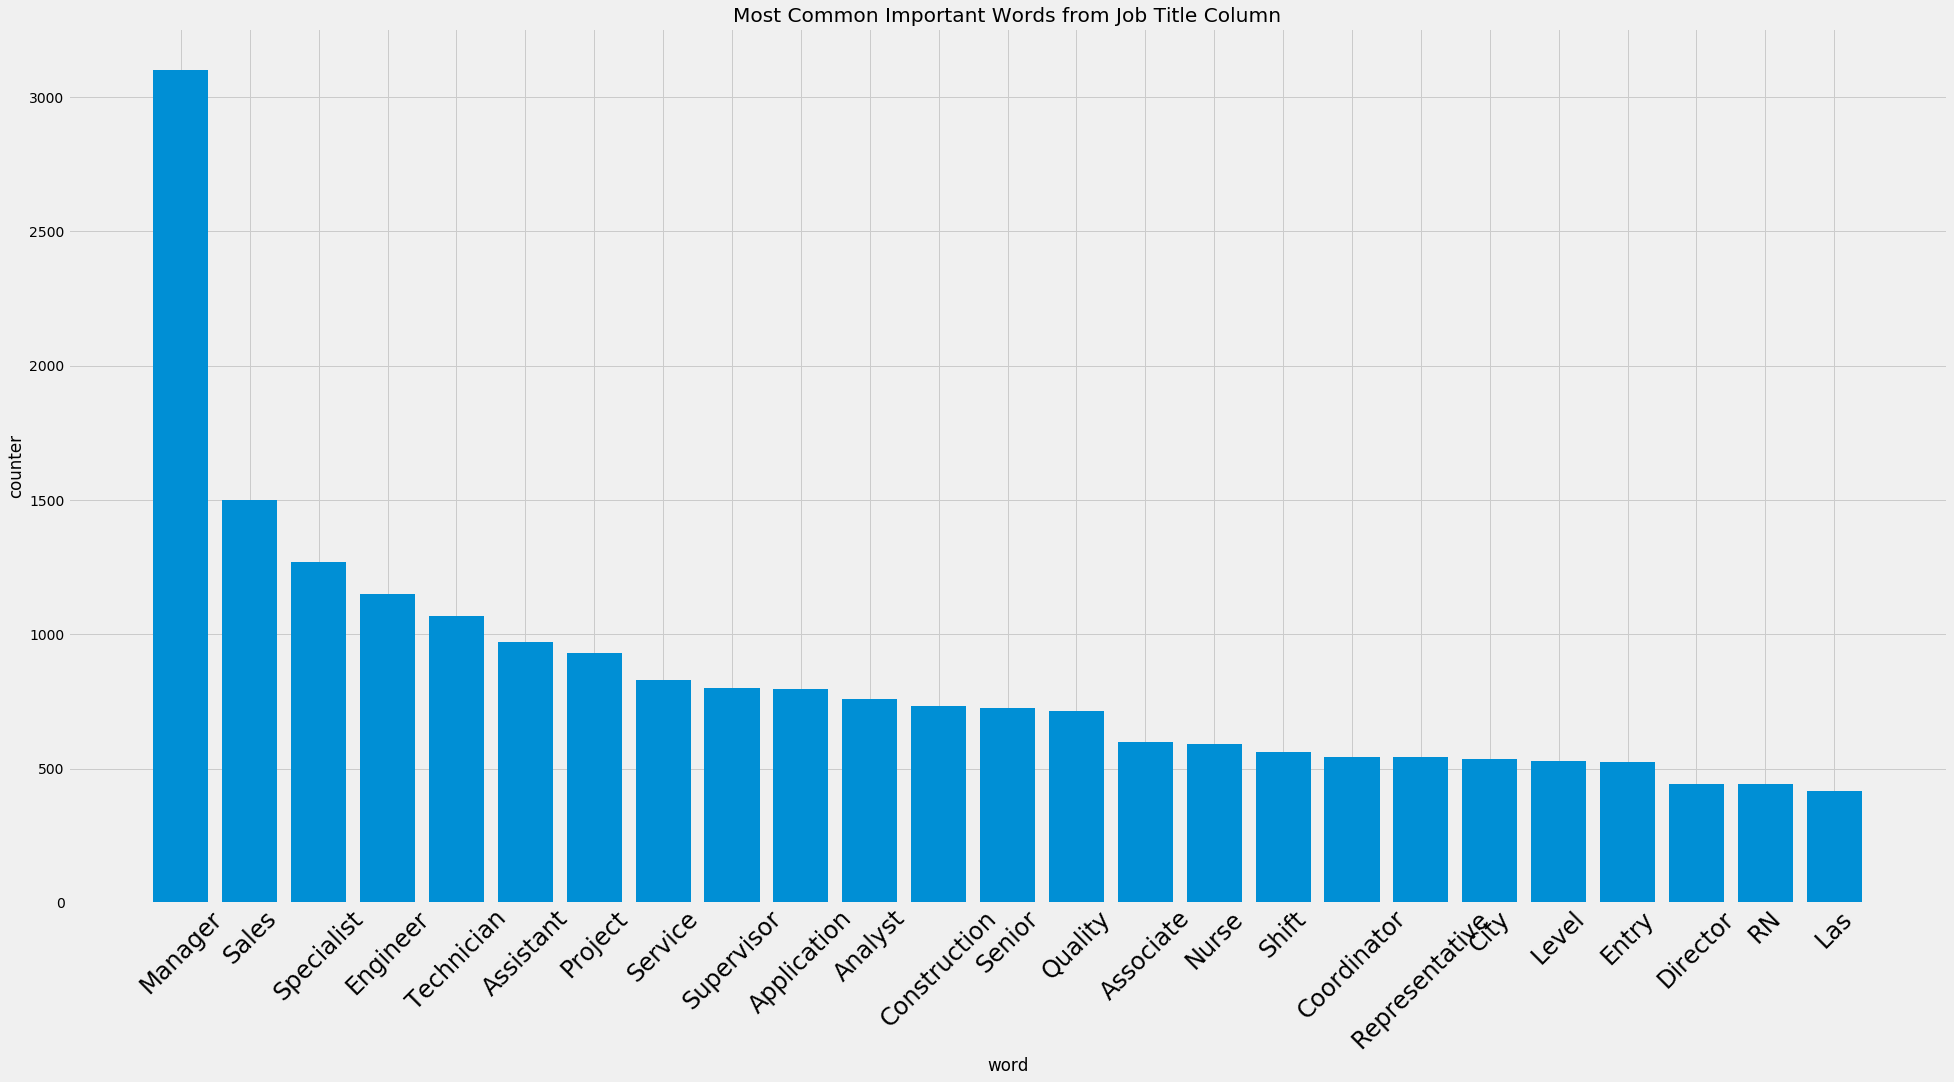

In [32]:
f, ax = plt.subplots(1,1, figsize=(30,15))
title_counter_25 = get_counter_object(job_titles).most_common(25)
title_counter_25 = generate_dict_from_tup_list(title_counter_25)
title_counter_25_len = len(title_counter_25)
ax.bar(range(title_counter_25_len), title_counter_25.values(), align='center')
ax.set_xticks(range(title_counter_25_len))
ax.set_xticklabels(title_counter.keys(), rotation=45, fontsize=24, minor=False)
ax.set_ylabel('counter')
ax.set_xlabel('word')
ax.set_title('Most Common Important Words from Job Title Column')
plt.show()

In [15]:
# function to print top terms found through clustering
def print_top_terms(model, k_val, vectorizer):
    print("Top terms per cluster:")
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    for i in range(k_val):
        print("Cluster %d:" % i),
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind]),
        print
    print("\n")

In [16]:
'''
creates kmeans model given feature to cluster based on vectorizing text
'''
def generate_kmeans_model(dataframe, feature_to_be_clustered, desired_label_col, k_val):
    # vectorizer
    vectorizer = TfidfVectorizer(stop_words=stop_words)
    
    # find k most frequent values to use as labels from desired column
    top_label_values = set([key for key in dataframe[desired_label_col].value_counts().head(k_val).to_dict()])
    # filter dataframe to only consider rows with top labels
    filter_df_by_top_label = dataframe[dataframe[desired_label_col].isin(top_label_values)]
    
    # create vectorized training set
    X = vectorizer.fit_transform(filter_df_by_top_label[feature_to_be_clustered])
    
    # create model
    model = KMeans(n_clusters=k_val, init='k-means++', max_iter=100, n_init=1)
    model.fit(X)
    return model, k_val, vectorizer

# function to save model
def save_model(model, model_name):
    save_classifier = open(model_name, 'wb')
    pickle.dump(model, save_classifier)
    save_classifier.close()

# function to open model from pickle
def open_model(model_name):
    model_file = open(model_name, "rb")
    model = pickle.load(model_file)
    model_file.close()
    return model
    

In [17]:
model, k_val, vectorizer = generate_kmeans_model(df, 'job_title', 'organization', 5)
print_top_terms(model, k_val, vectorizer)

Top terms per cluster:
Cluster 0:
 rn
 nurse
 registered
 job
 case
 manager
 antonio
 san
 home
 health
Cluster 1:
 time
 part
 full
 sales
 event
 job
 specialist
 supervisor
 camphill
 shift
Cluster 2:
 columbus
 associate
 sales
 lead
 job
 store
 pt
 mgr
 asst
 ft
Cluster 3:
 development
 manager
 job
 specialist
 business
 columbus
 houston
 senior
 cincinnati
 staff
Cluster 4:
 job
 supervisor
 manager
 shift
 camphill
 assistant
 dallas
 technician
 nurse
 service




In [79]:
'''
creates an encoding for input text based on most common bag of words
'''
def generate_encoded_features(bag_of_words, text):
    text = str(text)
    tokenized_text_set = set([word.lower() for word in word_tokenize(text)])
    feature_dict = {}
    for word in bag_of_words:
        word = str(word).lower()
        feature_dict[word] = (word in tokenized_text_set)
    return feature_dict

'''
generates a dataset containing encoded text as a feature and it's respective label
'''
def generate_encoded_data(dataframe,feature_col, label_col, most_common_words):
    data = []
    for _, row in dataframe.iterrows():
        data.append((generate_encoded_features(most_common_words, row[feature_col]), row[label_col]))
    return data    

In [19]:
# filter top 10 organization values
top_organization_values = set([key for key in df['organization'].value_counts().head(10).to_dict()])
organization_filtered_df = df[df['organization'].isin(top_organization_values)]
# generate data for classification
# use job_title as feature set
organization_prediction_data = generate_encoded_data(organization_filtered_df, 'job_title', 'organization',title_counter)

# cross validation 
# shuffle data
random.shuffle(organization_prediction_data)
# 75/25 train/test split
split = int(len(organization_prediction_data) * .75)
training_set = organization_prediction_data[:split]
test_set = organization_prediction_data[split:]

In [20]:
# MNB = Multinomial Naive Bayes Classifier 
# BNB = Bernoulli Naive Bayes Classifier 

MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)
print("MultinomialNB accuracy percent:",nltk.classify.accuracy(MNB_classifier, test_set))


BNB_classifier = SklearnClassifier(BernoulliNB())
BNB_classifier.train(training_set)
print("BernoulliNB accuracy percent:",nltk.classify.accuracy(BNB_classifier, test_set))

MultinomialNB accuracy percent: 0.5255988727101926
BernoulliNB accuracy percent: 0.5288868013151714


In [21]:
# use sector as feature set
organization_prediction_data = generate_encoded_data(organization_filtered_df, 'sector', 'organization',sec_counter)

# shuffle data
random.shuffle(organization_prediction_data)
# 75/25 train/test split
split = int(len(organization_prediction_data) * .75)
training_set = organization_prediction_data[:split]
test_set = organization_prediction_data[split:]

In [22]:
MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)
print("MultinomialNB accuracy percent:",nltk.classify.accuracy(MNB_classifier, test_set))


BNB_classifier = SklearnClassifier(BernoulliNB())
BNB_classifier.train(training_set)
print("BernoulliNB accuracy percent:",nltk.classify.accuracy(BNB_classifier, test_set))

MultinomialNB accuracy percent: 0.3034288398309065
BernoulliNB accuracy percent: 0.31611085016439644


In [23]:
organization_prediction_data = generate_encoded_data(organization_filtered_df, 'job_description', 'organization',desc_counter)

# shuffle data
random.shuffle(organization_prediction_data)
# 75/25 train/test split
split = int(len(organization_prediction_data) * .75)
training_set = organization_prediction_data[:split]
test_set = organization_prediction_data[split:]

In [39]:
MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)
print("MultinomialNB accuracy percent:",nltk.classify.accuracy(MNB_classifier, test_set))


BNB_classifier = SklearnClassifier(BernoulliNB(`))
BNB_classifier.train(training_set)
print("BernoulliNB accuracy percent:",nltk.classify.accuracy(BNB_classifier, test_set))

MultinomialNB accuracy percent: 0.5782057303898543
BernoulliNB accuracy percent: 0.5241897604509159


In [40]:
# create bag of words to generate feature vector for nn
def create_lexicon(df, feature_col):
    all_tokens = []
    for _, row in df.iterrows():
        # tokenize row of feature column
        words = word_tokenize(row[feature_col])
        for word in words:
            # remove unwanted words
            word = strip_word_remove_location(word)
            if (not word in stop_words):
                # append to all_token list
                all_tokens.append(word.lower())
    # simplify words to their root using lemmatizer 
    all_tokens = [lemmatizer.lemmatize(i) for i in all_tokens]
    # create counter object
    all_token_counts = Counter(all_tokens)
    
    lexicon = []
    # only use values between certain thresholds
    for tok in all_token_counts:
        if (1000 > all_token_counts[tok] > 100):
            lexicon.append(tok)
    return lexicon

# generate feature set and label for each sample
def sample_handling(df, feature_col, label_col, label_dict, lexicon):
    featureset = []
    for _, row in df.iterrows():
        # use one hot encoding for label
        classification_arr = [0] * len(label_dict)
        # get feature vector
        words = word_tokenize(row[feature_col].lower())
        words = [lemmatizer.lemmatize(i) for i in words]
        features = np.zeros(len(lexicon))
        
        # create encoded feature vector
        for word in words:
            word = word.lower()
            if(word in lexicon):
                index_value = lexicon.index(word)
                features[index_value] += 1
        
        features = list(features)
        # one hot encode label 
        classification_arr[label_dict[row[label_col]]] = 1
        # add to featureset
        featureset.append([features, classification_arr])
    return featureset

# generate features, labels and return appropriate cross validation
def create_feature_sets_and_labels(df, feature_col, label_col, label_dict, test_size=.25):
    # create bag of words
    lexicon = create_lexicon(df, feature_col)
    features = []
    # make features
    features += sample_handling(df, feature_col, label_col, label_dict, lexicon)
    # shuffle for randomness
    random.shuffle(features)
    
    # use numpy arrays for nice indexing
    features = np.array(features)
    testing_size = int(test_size * len(features))
    
    '''
    quick example for why this works
        a = [] + [[[1,2,3],[1,3]]]* 5
        a = np.array(a)
        testing_size = int(.25 * len(a))
        print(testing_size)
        list(a[:,0][:-testing_size])
    '''
    # cross validate splits
    train_x = list(features[:,0][:-testing_size])
    train_y = list(features[:,1][:-testing_size])
    test_x = list(features[:,0][-testing_size:])
    test_y = list(features[:,1][-testing_size:])
    
    return train_x, train_y, test_x, test_y

In [46]:
# number of nodes in each hidden layer
n_nodes_hl1 = 1500
n_nodes_hl2 = 1500
n_nodes_hl3 = 1500
# go through batches of elements
batch_size = 100

# function to create nn model
def neural_network_model(input_data,train_x, n_classes):
    hidden_1_layer = {'weights': tf.Variable(tf.random_normal([len(train_x[0]), n_nodes_hl1])),
                     'biases': tf.Variable(tf.random_normal([n_nodes_hl1]))}
    
    hidden_2_layer = {'weights': tf.Variable(tf.random_normal([n_nodes_hl1, n_nodes_hl2])),
                     'biases': tf.Variable(tf.random_normal([n_nodes_hl2]))}
    
    hidden_3_layer = {'weights': tf.Variable(tf.random_normal([n_nodes_hl2, n_nodes_hl3])),
                     'biases': tf.Variable(tf.random_normal([n_nodes_hl3]))}
    
    output_layer = {'weights': tf.Variable(tf.random_normal([n_nodes_hl3, n_classes])),
                     'biases': tf.Variable(tf.random_normal([n_classes]))}
    
    # (input_data * weights) + biases then apply activation function for each layer
    l1 = tf.add(tf.matmul(input_data, hidden_1_layer['weights']) , hidden_1_layer['biases'])
    l1 = tf.nn.relu(l1)
    
    l2 = tf.add(tf.matmul(l1, hidden_2_layer['weights']), hidden_2_layer['biases'])
    l2 = tf.nn.relu(l2)
    
    l3 = tf.add(tf.matmul(l2, hidden_3_layer['weights']) , hidden_3_layer['biases'])
    l3 = tf.nn.relu(l3)
    
    output = tf.matmul(l3, output_layer['weights']) + output_layer['biases']
    
    return output

def train_neural_network(train_x, train_y, test_x, test_y, x, y, n_classes):
    prediction = neural_network_model(x,train_x,n_classes)
    #print(prediction)
    # cross entropy with logit calculates the difference between the known label and prediction
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction,labels=y))
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    # cycles of feed forward and back prop
    hm_epochs = 10
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        
        for epoch in range(hm_epochs):
            # calculate loss for each iteration
            epoch_loss = 0
            i = 0
            while i < len(train_x):
                # batch to show improvement
                start = i
                end = i+batch_size
                
                batch_x = np.array(train_x[start:end])
                batch_y = np.array(train_y[start:end])
                # train by passing optimzation and cost function along with data to sess.run()
                _, c = sess.run([optimizer, cost], feed_dict={x:batch_x, y:batch_y})
                epoch_loss += c
                i += batch_size
            print('epoch: ', epoch, ' completed out of', hm_epochs, ' loss: ' , epoch_loss)
        # view performance
        correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y,1))
        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        print('accuracy: ' , accuracy.eval({x:test_x, y:test_y}))
        
def run_nn_model(feature_col, label_col,label_dict,filtered_df, num_labels):
    # cross validation 
    train_x,train_y,test_x,test_y = create_feature_sets_and_labels(filtered_df, feature_col, label_col, label_dict)
    
    # input data
    # placeholder for features
    x = tf.placeholder('float', [None, len(train_x[0])])
    # placeholder for labels
    y = tf.placeholder('float')
    
    train_neural_network(train_x,train_y,test_x,test_y, x, y, num_labels)

In [47]:
num_labels = 5
# select number of labels to predict
top_org_values = set([key for key in df['organization'].value_counts().head(num_labels).to_dict()])
# filter for only those in desired label set
filter_by_top_org_values = df[df['organization'].isin(top_org_values)]
# create list from values with corresponding dictionary with index values for one hot encoding
top_org_values_list = list(top_org_values)
org_dict = {top_org_values_list[i]:i for i in range(len(top_org_values_list))}

In [48]:
run_nn_model('job_description', 'organization',org_dict,filter_by_top_org_values,num_labels)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
epoch:  0  completed out of 10  loss:  8810531.83594
epoch:  1  completed out of 10  loss:  2602176.83008
epoch:  2  completed out of 10  loss:  1455076.19531
epoch:  3  completed out of 10  loss:  1032154.02637
epoch:  4  completed out of 10  loss:  828708.636719
epoch:  5  completed out of 10  loss:  1125767.78198
epoch:  6  completed out of 10  loss:  631331.441284
epoch:  7  completed out of 10  loss:  433780.079102
epoch:  8  completed out of 10  loss:  492813.088135
epoch:  9  completed out of 10  loss:  252492.331299
accuracy:  0.721419
